In [1]:
%reload_ext autoreload
%autoreload 2

In [10]:
# Standard python libraries
import os
import time
import requests
import warnings


# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# import torch

# Imports from our package
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.boost_cb import BoostCB
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.pipelines.selection.importance_based import (
    ImportanceCutoffSelector,
    ModelBasedImportanceEstimator,
)
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.automl.blend import WeightedBlender
from lightautoml.automl.presets.tabular_presets import (
    TabularAutoML,
    TabularUtilizedAutoML,
)
from lightautoml.dataset.roles import DatetimeRole

from funcs import (
    get_num_features, 
    get_cat_features,
    create_features,
    get_mae,
    playsound,
    target_log1p,
)

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", None)

In [3]:
N_THREADS = 8  # threads cnt for lgbm and linear models
N_FOLDS = 5  # folds cnt for AutoML
RANDOM_STATE = 137  # fixed random state for various reasons
TEST_SIZE = 0.2  # Test size for metric check
TARGET_NAME = "SalePrice"  # Target column name

np.random.seed(RANDOM_STATE)


DATASET_DIR = "data/"
TRAIN_DATASET_NAME = "train.csv"
TEST_DATASET_NAME = "train.csv"
TRAIN_DATASET_FULLNAME = os.path.join(DATASET_DIR, TRAIN_DATASET_NAME)
TEST_DATASET_FULLNAME = os.path.join(DATASET_DIR, TEST_DATASET_NAME)


TIMEOUT = 3600
THREADS = 4
CV = 5

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_FULLNAME)
test_df = pd.read_csv(TEST_DATASET_FULLNAME)
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_df_fe = create_features(train_df)
test_df_fe = create_features(test_df)

In [6]:
num_features = get_num_features(train_df_fe)
cat_features = get_cat_features(train_df_fe)

In [7]:
task = Task("reg", metric="mae")

In [8]:
roles = {
    "target": TARGET_NAME,
    "category": cat_features,
    "numeric": num_features,
}

# 1. TabularAutoML

In [30]:
%%time
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=THREADS,
    reader_params = {'n_jobs': THREADS, 'random_state': RANDOM_STATE, 'cv': CV},
    general_params={'use_algos': [['lgb', 'cb', 'lgb_tuned', 'cb_tuned', 'xgb', 'xgb_tuned']]},
)


CPU times: total: 0 ns
Wall time: 18.6 ms


In [31]:
from lightautoml.report.report_deco import ReportDeco


RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    automl
)

oof_pred = automl_rd.fit_predict(train_df_fe, roles = roles, verbose = 1)

[19:37:54] Stdout logging level is INFO.
[19:37:54] Task: reg

[19:37:54] Start automl preset with listed constraints:
[19:37:54] - time: 3600.00 seconds
[19:37:54] - CPU: 4 cores
[19:37:54] - memory: 16 GB

[19:37:54] Train data shape: (1460, 91)

[19:37:59] Layer 1 train process start. Time left 3594.81 secs
[19:38:00] Selector_LightGBM fitting and predicting completed
[19:38:00] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[19:38:04] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -15990.206621896405
[19:38:04] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[19:38:04] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [01:27<00:00,  1.15it/s, best_trial=77, best_value=-1.46e+4]

[19:39:32] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[19:39:32] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[19:39:33] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -15770.901212007706
[19:39:33] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[19:39:33] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[19:39:39] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -15392.137561536814
[19:39:39] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[19:39:39] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Exception ignored in: <function Booster.__del__ at 0x000001C110882200>
Traceback (most recent call last):
  File "c:\Users\User\skillbox\HOMEWORKS\HWs\Lib\site-packages\lightgbm\basic.py", line 3713, in __del__
    _safe_call(_LIB.LGBM_BoosterFree(self._handle))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: exception: access violation reading 0xFFFFFFFFFFFFFFFF
Optimization Progress: 100%|██████████| 101/101 [01:47<00:00,  1.06s/it, best_trial=98, best_value=-1.48e+4]

[19:41:26] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[19:41:26] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[19:41:30] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -15199.133010488014
[19:41:30] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[19:41:30] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[19:41:36] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -17708.02184824486
[19:41:36] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[19:41:36] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress:  91%|█████████ | 92/101 [05:02<00:29,  3.28s/it, best_trial=42, best_value=-1.5e+4] 

[19:46:38] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[19:46:38] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[19:46:53] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -15886.25225010702
[19:46:53] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[19:46:53] Time left 3061.58 secs

[19:46:53] Layer 1 training completed.

[19:46:53] Blending: optimization starts with equal weights. Score = -15219.6183995
[19:46:53] Blending: iteration 0: score = -14969.6179688, weights = [0.         0.0780202  0.30118278 0.54482317 0.07597386 0.        ]
[19:46:53] Blending: iteration 1: score = -14942.9846104, weights = [0.         0.20653504 0.24665403 0.48914894 0.057662   0.        ]
[19:46:53] Blending: iteration 2: score = -14941.3443841, weights = [0.         0.22060794 0.24546716 0.48131558 0.05260937 0.        ]
[19:46:53] Blending: iteration 3: score = -14940.5679019, weights = [0.         0.23159336 0.25489444 0.4626338  0.05087845 0.        ]
[19:46:53] Blending: no improvements for score. Terminated.

[19:46:53] Blending: best score = -14940.5679019, best weights = [0.  

In [32]:
get_mae(automl, oof_pred, train_df_fe, test_df_fe)

MAE on train: 14940.567901862158
MAE on test: 8368.85595301798


**Ого! Неплохо-неплохо я фичей насоздавал. Здесь не сохранилось, но изначально скор был под 16k. Ну, попробуем TabularUtilizedAutoML. Пока оно тут пахало, накатал функцию под импутацию отсутствующих значений, но теперь не знаю, надо ли проверять.**

# 2. TabularUtilizedAutoML

In [33]:
automl_ut = TabularUtilizedAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=THREADS,
    reader_params = {'n_jobs': THREADS, 'random_state': RANDOM_STATE, 'cv': CV},
    general_params={'use_algos': [['lgb', 'cb', 'lgb_tuned', 'cb_tuned', 'xgb', 'xgb_tuned']]},
)

In [34]:
oof_pred_ut = automl_ut.fit_predict(train_df_fe, roles = roles, verbose = 1)

[19:54:12] Start automl utilizator with listed constraints:
[19:54:12] - time: 3600.00 seconds
[19:54:12] - CPU: 4 cores
[19:54:12] - memory: 16 GB

[19:54:12] If one preset completes earlier, next preset configuration will be started

[19:54:12] ==================================================
[19:54:12] Start 0 automl preset configuration:
[19:54:12] c:\Users\User\skillbox\HOMEWORKS\HWs\Lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[19:54:12] Stdout logging level is INFO.
[19:54:12] Task: reg

[19:54:12] Start automl preset with listed constraints:
[19:54:12] - time: 3600.00 seconds
[19:54:12] - CPU: 4 cores
[19:54:12] - memory: 16 GB

[19:54:12] Train data shape: (1460, 91)

[19:54:17] Layer 1 train process start. Time left 3595.07 secs
[19:54:18] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[19:54:22] 

Optimization Progress: 100%|██████████| 101/101 [02:38<00:00,  1.57s/it, best_trial=74, best_value=-1.52e+4]

[19:57:00] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[19:57:00] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[19:57:02] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -15798.178676155821
[19:57:02] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[19:57:02] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[19:57:11] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -15119.528047410102
[19:57:11] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[19:57:11] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [04:49<00:00,  2.87s/it, best_trial=70, best_value=-1.48e+4]

[20:02:00] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[20:02:00] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[20:02:10] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -15285.693225599314
[20:02:10] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[20:02:10] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[20:02:20] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -18701.194764019692
[20:02:20] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[20:02:20] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress:  50%|█████     | 51/101 [05:00<04:55,  5.90s/it, best_trial=44, best_value=-1.5e+4] 

[20:07:21] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[20:07:21] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[20:07:46] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -16360.581413206335
[20:07:46] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[20:07:46] Time left 2786.23 secs

[20:07:46] Layer 1 training completed.

[20:07:46] Blending: optimization starts with equal weights. Score = -15356.0859803
[20:07:46] Blending: iteration 0: score = -14898.9416765, weights = [0.         0.07546478 0.5405021  0.29742232 0.         0.08661082]
[20:07:46] Blending: iteration 1: score = -14872.4746067, weights = [0.         0.18109442 0.44288915 0.37601644 0.         0.        ]
[20:07:46] Blending: iteration 2: score = -14867.2716422, weights = [0.         0.21770084 0.42755625 0.35474288 0.         0.        ]
[20:07:46] Blending: no improvements for score. Terminated.

[20:07:46] Blending: best score = -14867.2716422, best weights = [0.         0.21770084 0.42755625 0.35474288 0.         0.        ]
[20:07:46] Automl preset training completed in 813.92 seconds

[20:07:46

Optimization Progress: 100%|██████████| 101/101 [01:17<00:00,  1.31it/s, best_trial=35, best_value=-1.52e+4]

[20:09:14] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[20:09:14] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[20:09:15] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -15594.059219820205
[20:09:15] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:09:15] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[20:09:20] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -15050.269547303082
[20:09:20] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[20:09:20] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [01:50<00:00,  1.09s/it, best_trial=95, best_value=-1.47e+4]

[20:11:10] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[20:11:10] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[20:11:22] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -14805.265809610446
[20:11:22] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[20:11:22] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[20:11:32] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -18177.378258775683
[20:11:32] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[20:11:32] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress:  66%|██████▋   | 67/101 [05:08<02:36,  4.60s/it, best_trial=32, best_value=-1.55e+4]

[20:16:41] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[20:16:41] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[20:17:02] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -15649.656752996576
[20:17:02] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[20:17:02] Time left 2230.33 secs

[20:17:02] Layer 1 training completed.

[20:17:02] Blending: optimization starts with equal weights. Score = -15132.8486007
[20:17:02] Blending: iteration 0: score = -14742.3100760, weights = [0.         0.         0.24542782 0.626999   0.         0.12757319]
[20:17:02] Blending: iteration 1: score = -14742.0202697, weights = [0.         0.         0.22433485 0.6389037  0.         0.13676152]
[20:17:02] Blending: iteration 2: score = -14741.9598298, weights = [0.         0.         0.21748668 0.64326656 0.         0.13924675]
[20:17:02] Blending: no improvements for score. Terminated.

[20:17:02] Blending: best score = -14741.9598298, best weights = [0.         0.         0.21748668 0.64326656 0.         0.13924675]
[20:17:02] Automl preset training completed in 555.91 seconds

[20:17:02

Optimization Progress: 100%|██████████| 101/101 [01:32<00:00,  1.09it/s, best_trial=93, best_value=-1.5e+4]

[20:18:41] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[20:18:41] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[20:18:42] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -16061.411563570206
[20:18:42] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:18:42] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[20:18:50] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -15571.528432684076
[20:18:50] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[20:18:50] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [03:23<00:00,  2.01s/it, best_trial=17, best_value=-1.5e+4]

[20:22:14] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[20:22:14] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[20:22:21] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -15306.969662350171
[20:22:21] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[20:22:21] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[20:22:29] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -18405.56665239726
[20:22:29] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[20:22:29] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress:  80%|████████  | 81/101 [05:06<01:15,  3.79s/it, best_trial=73, best_value=-1.52e+4]

[20:27:36] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[20:27:36] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[20:27:55] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -16144.929580479453
[20:27:55] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[20:27:55] Time left 1577.32 secs

[20:27:55] Layer 1 training completed.

[20:27:55] Blending: optimization starts with equal weights. Score = -15535.9783578
[20:27:55] Blending: iteration 0: score = -15215.1470489, weights = [0.         0.06880526 0.2494438  0.62549144 0.         0.05625952]
[20:27:55] Blending: iteration 1: score = -15187.1115234, weights = [0.05391134 0.189755   0.22670466 0.529629   0.         0.        ]
[20:27:55] Blending: iteration 2: score = -15182.3966021, weights = [0.         0.20822951 0.18463095 0.6071395  0.         0.        ]
[20:27:55] Blending: iteration 3: score = -15178.7003532, weights = [0.         0.23549297 0.22908665 0.53542036 0.         0.        ]
[20:27:55] Blending: iteration 4: score = -15178.6133535, weights = [0.         0.2421128  0.21916686 0.5387203  0.         0.    

Optimization Progress: 100%|██████████| 101/101 [01:53<00:00,  1.13s/it, best_trial=25, best_value=-1.45e+4]

[20:30:26] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[20:30:26] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[20:30:28] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -15622.103026005992
[20:30:28] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:30:28] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[20:30:40] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -14578.441831656679
[20:30:40] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[20:30:40] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [03:10<00:00,  1.89s/it, best_trial=73, best_value=-1.38e+4]

[20:33:51] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[20:33:51] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[20:33:57] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -14995.022420804795
[20:33:57] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[20:33:57] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[20:34:06] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -17296.354141695207
[20:34:06] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[20:34:06] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress:  75%|███████▌  | 76/101 [05:01<01:39,  3.97s/it, best_trial=62, best_value=-1.44e+4]

[20:39:08] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[20:39:08] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[20:39:28] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -14931.160065282535
[20:39:28] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[20:39:28] Time left 884.13 secs

[20:39:28] Layer 1 training completed.

[20:39:28] Blending: optimization starts with equal weights. Score = -14805.2577750
[20:39:29] Blending: iteration 0: score = -14427.0000696, weights = [0.         0.         0.5363852  0.17748739 0.         0.28612742]
[20:39:29] Blending: iteration 1: score = -14426.5426209, weights = [0.         0.         0.55986154 0.1546544  0.         0.28548402]
[20:39:29] Blending: iteration 2: score = -14426.5400417, weights = [0.         0.         0.557475   0.15860382 0.         0.28392127]
[20:39:29] Blending: iteration 3: score = -14426.5350920, weights = [0.         0.         0.55393785 0.16211525 0.         0.28394696]
[20:39:29] Blending: no improvements for score. Terminated.

[20:39:29] Blending: best score = -14426.5350920, best weights = [0.  

Optimization Progress:  83%|████████▎ | 84/101 [01:50<00:22,  1.31s/it, best_trial=52, best_value=-1.41e+4]

[20:41:32] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[20:41:32] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[20:41:34] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -15274.860528146404
[20:41:34] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:41:34] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[20:41:52] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -14612.358414490582
[20:41:52] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[20:41:52] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [04:26<00:00,  2.63s/it, best_trial=31, best_value=-1.35e+4]

[20:46:18] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[20:46:18] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[20:46:38] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -14838.367091181506
[20:46:38] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[20:46:38] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[20:46:47] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -17360.432534246575
[20:46:47] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[20:46:47] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress:  62%|██████▏   | 63/101 [05:02<03:02,  4.80s/it, best_trial=12, best_value=-1.38e+4]

[20:51:50] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[20:51:50] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[20:52:13] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -14898.031314212329
[20:52:13] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[20:52:13] Time left 119.92 secs

[20:52:13] Layer 1 training completed.

[20:52:13] Blending: optimization starts with equal weights. Score = -14605.5201975
[20:52:13] Blending: iteration 0: score = -14419.2585349, weights = [0.         0.07226162 0.46719557 0.18676287 0.05722149 0.21655844]
[20:52:13] Blending: iteration 1: score = -14409.9804928, weights = [0.         0.14369766 0.5385284  0.09776998 0.         0.22000399]
[20:52:13] Blending: iteration 2: score = -14408.8964897, weights = [0.         0.12417015 0.5164739  0.11975761 0.         0.23959832]
[20:52:13] Blending: no improvements for score. Terminated.

[20:52:13] Blending: best score = -14408.8964897, best weights = [0.         0.12417015 0.5164739  0.11975761 0.         0.23959832]
[20:52:13] Automl preset training completed in 764.10 seconds

[20:52:13]

In [35]:
get_mae(automl_ut, oof_pred_ut, train_df_fe, test_df_fe)

pygame 2.6.1 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
MAE on train: 14183.078547731164
MAE on test: 6293.234658604452


In [36]:
print(automl_ut.create_model_str_desc())

Final prediction for new objects = 
	0.14855 * 1 averaged models with config = "c:\Users\User\skillbox\HOMEWORKS\HWs\Lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.21749 * (5 averaged models Lvl_0_Pipe_0_Mod_2_CatBoost) +
			 0.64327 * (5 averaged models Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost) +
			 0.13925 * (5 averaged models Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost) 


	+ 0.37449 * 1 averaged models with config = "c:\Users\User\skillbox\HOMEWORKS\HWs\Lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_3_sel_type_1_no_inter_lgbm.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.55394 * (5 averaged models Lvl_0_Pipe_0_Mod_2_CatBoost) +
			 0.16212 * (5 averaged models Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost) +
			 0.28395 * (5 averaged models Lvl_0_Pipe_0_Mod_

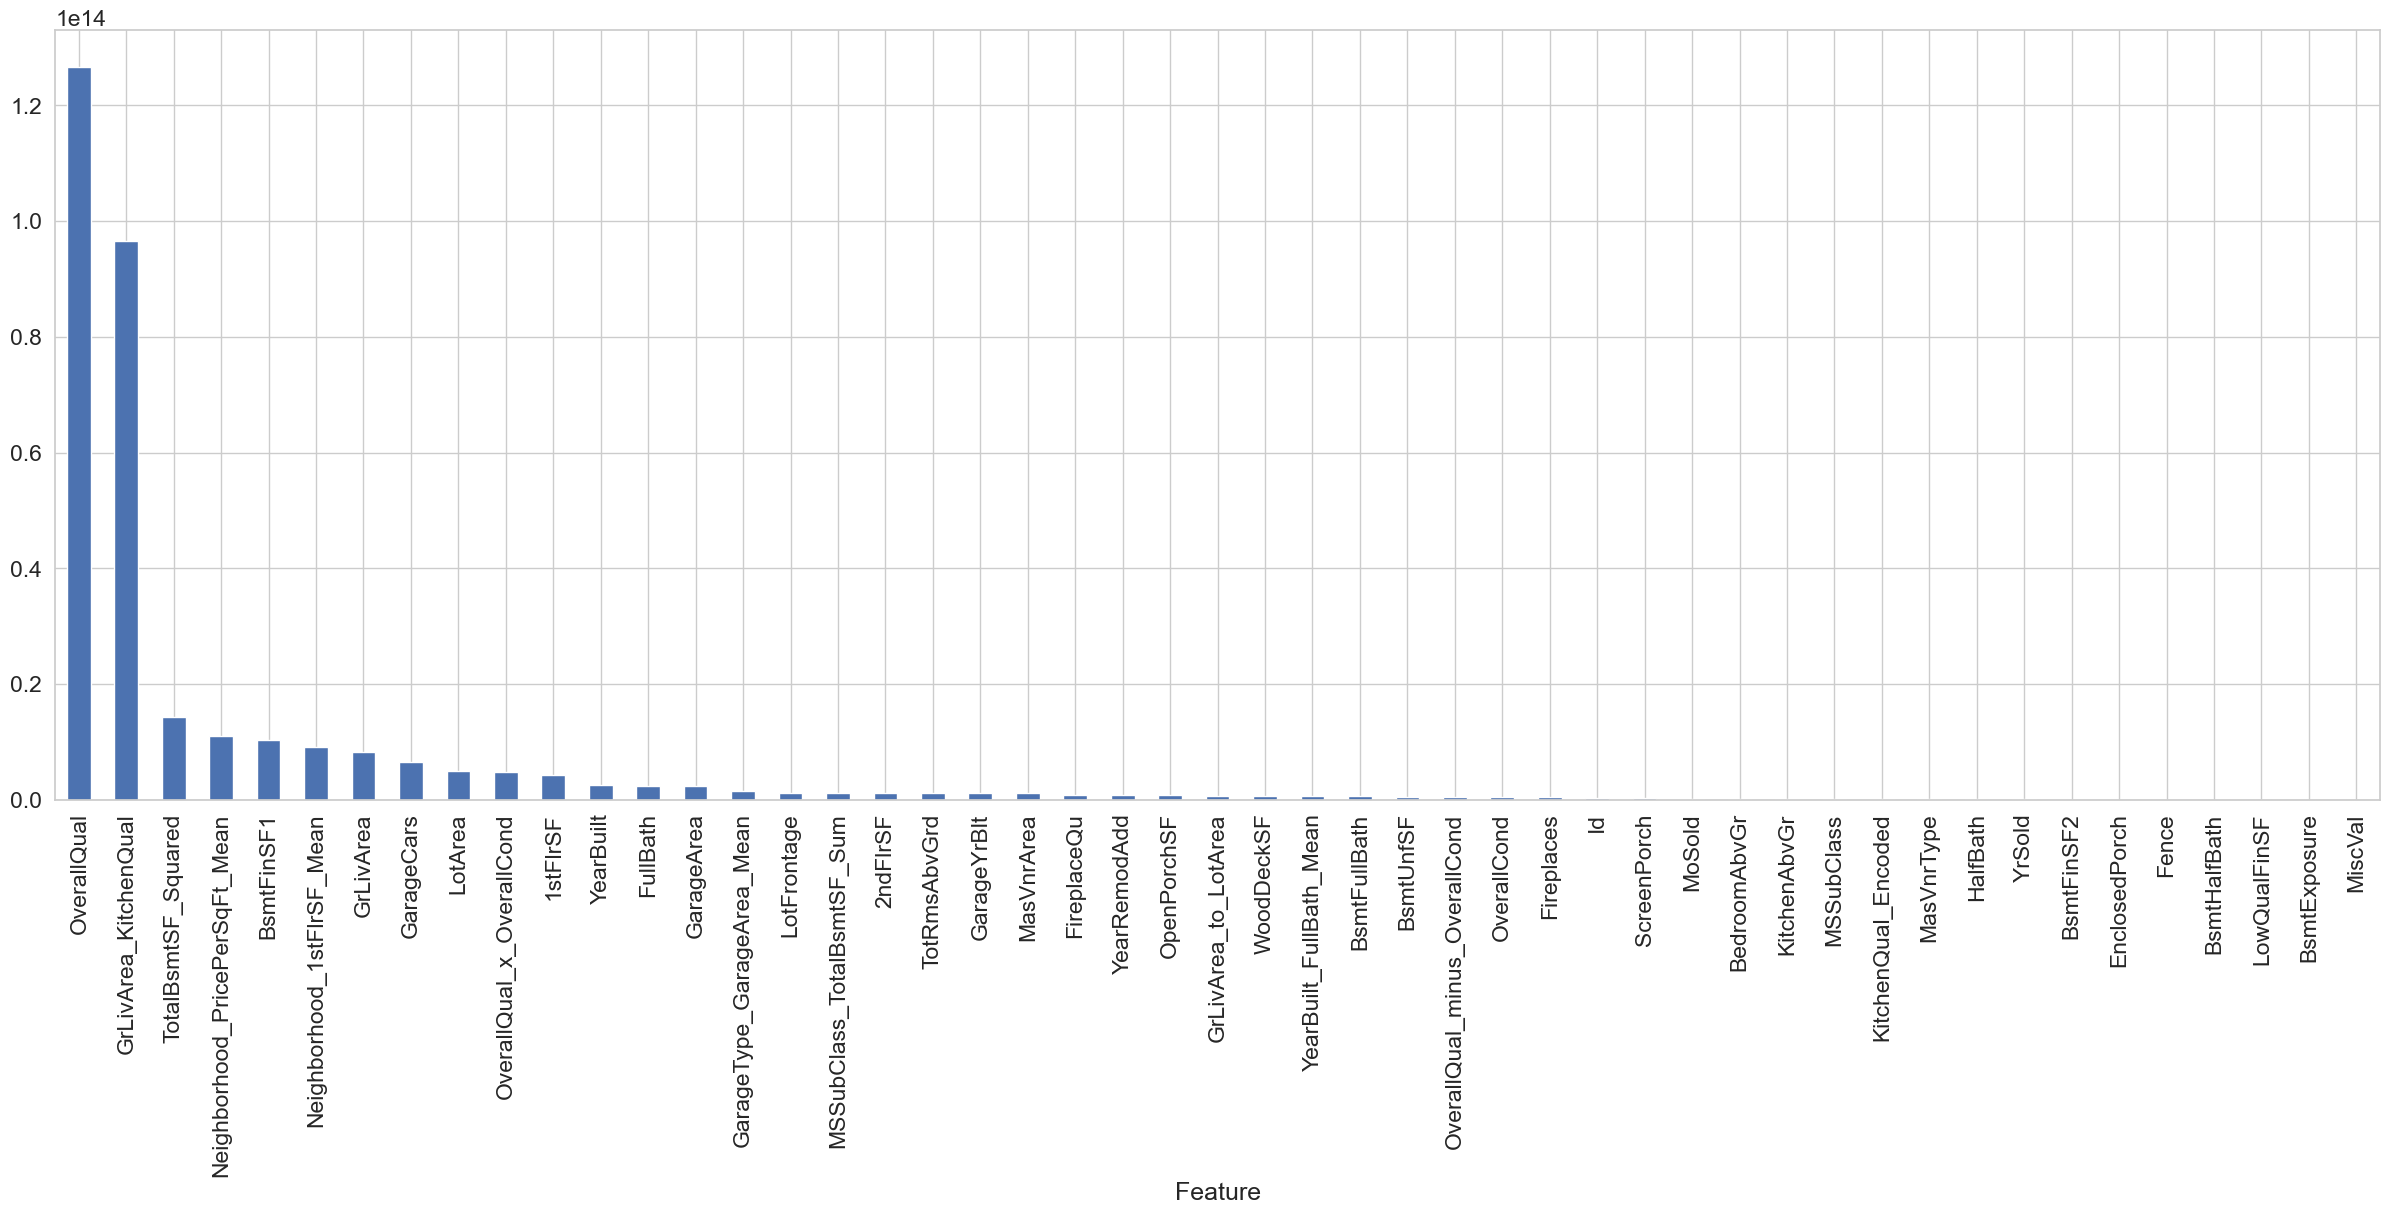

In [39]:
fast_fi = automl_ut.get_feature_scores('fast', test_data, silent=True)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True);

In [43]:
playsound()

# 3. Logarithmisation

**Не могу не проверить, как повлияет логарифмизация таргета на МАЕ.**

In [12]:
train_df_fe = target_log1p(train_df_fe)
test_df_fe = target_log1p(test_df_fe)

In [14]:
automl_ut = TabularUtilizedAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=THREADS,
    reader_params = {'n_jobs': THREADS, 'random_state': RANDOM_STATE, 'cv': CV},
    general_params={'use_algos': [['lgb', 'cb', 'lgb_tuned', 'cb_tuned', 'xgb', 'xgb_tuned']]},
)

In [15]:
oof_pred_ut = automl_ut.fit_predict(train_df_fe, roles = roles, verbose = 1)

[09:21:02] Start automl utilizator with listed constraints:
[09:21:02] - time: 3600.00 seconds
[09:21:02] - CPU: 4 cores
[09:21:02] - memory: 16 GB

[09:21:02] If one preset completes earlier, next preset configuration will be started

[09:21:02] ==================================================
[09:21:02] Start 0 automl preset configuration:
[09:21:02] c:\Users\User\skillbox\HOMEWORKS\HWs\Lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[09:21:02] Stdout logging level is INFO.
[09:21:02] Task: reg

[09:21:02] Start automl preset with listed constraints:
[09:21:02] - time: 3600.00 seconds
[09:21:02] - CPU: 4 cores
[09:21:02] - memory: 16 GB

[09:21:02] Train data shape: (1460, 91)

[09:21:08] Layer 1 train process start. Time left 3594.19 secs
[09:21:08] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[09:21:15] 

Optimization Progress: 100%|██████████| 101/101 [01:53<00:00,  1.12s/it, best_trial=81, best_value=-0.0862]

[09:23:08] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[09:23:08] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[09:23:09] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.08699443848079931
[09:23:09] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[09:23:09] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[09:23:16] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -0.08513228370880617
[09:23:16] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[09:23:16] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [04:32<00:00,  2.70s/it, best_trial=82, best_value=-0.0824]

[09:27:49] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[09:27:49] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[09:28:02] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -0.08301203376008856
[09:28:02] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[09:28:02] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[09:28:04] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -0.09947171561955881
[09:28:04] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[09:28:04] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress:  66%|██████▋   | 67/101 [05:24<02:44,  4.85s/it, best_trial=53, best_value=-0.0848]

[09:33:29] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[09:33:29] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[09:34:35] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -0.08588042652534852
[09:34:35] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[09:34:35] Time left 2787.17 secs

[09:34:35] Layer 1 training completed.

[09:34:35] Blending: optimization starts with equal weights. Score = -0.0841288
[09:34:35] Blending: iteration 0: score = -0.0823688, weights = [0.         0.0722523  0.17711687 0.5453333  0.         0.20529753]
[09:34:35] Blending: iteration 1: score = -0.0822772, weights = [0.         0.17854856 0.15059756 0.536449   0.         0.13440491]
[09:34:35] Blending: iteration 2: score = -0.0822753, weights = [0.         0.19419591 0.15299536 0.5220192  0.         0.13078958]
[09:34:35] Blending: no improvements for score. Terminated.

[09:34:35] Blending: best score = -0.0822753, best weights = [0.         0.19419591 0.15299536 0.5220192  0.         0.13078958]
[09:34:35] Automl preset training completed in 813.00 seconds

[09:34:35] Model description

Optimization Progress: 100%|██████████| 101/101 [02:23<00:00,  1.42s/it, best_trial=44, best_value=-0.0805]

[09:37:13] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[09:37:13] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[09:37:15] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.08562169524095507
[09:37:15] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[09:37:15] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[09:37:25] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -0.08411154151836223
[09:37:25] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[09:37:25] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [02:08<00:00,  1.27s/it, best_trial=82, best_value=-0.0821]

[09:39:33] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[09:39:33] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[09:39:38] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -0.08391458782360847
[09:39:38] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[09:39:38] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[09:39:39] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -0.09709625715225186
[09:39:39] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[09:39:39] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [05:01<00:00,  2.98s/it, best_trial=93, best_value=-0.082]

[09:44:40] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[09:44:40] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[09:45:01] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -0.08437955895841535
[09:45:01] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[09:45:01] Time left 2161.71 secs

[09:45:01] Layer 1 training completed.

[09:45:01] Blending: optimization starts with equal weights. Score = -0.0828575
[09:45:01] Blending: iteration 0: score = -0.0820745, weights = [0.         0.11712115 0.27736026 0.31359953 0.         0.29191908]
[09:45:01] Blending: iteration 1: score = -0.0820350, weights = [0.         0.19770701 0.23899513 0.31231806 0.         0.2509798 ]
[09:45:01] Blending: no improvements for score. Terminated.

[09:45:01] Blending: best score = -0.0820350, best weights = [0.         0.19770701 0.23899513 0.31231806 0.         0.2509798 ]
[09:45:01] Automl preset training completed in 625.34 seconds

[09:45:01] Model description:
Final prediction for new objects (level 0) = 
	 0.19771 * (5 averaged models Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM) +
	 0.23900 * (5 a

Optimization Progress: 100%|██████████| 101/101 [01:36<00:00,  1.05it/s, best_trial=77, best_value=-0.0884]

[09:46:45] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[09:46:45] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[09:46:47] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.08809090091206129
[09:46:47] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[09:46:47] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[09:46:55] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -0.085958719876984
[09:46:55] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[09:46:55] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [03:19<00:00,  1.97s/it, best_trial=86, best_value=-0.0876]

[09:50:14] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[09:50:14] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[09:50:25] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -0.08489741050225655
[09:50:25] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[09:50:25] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[09:50:27] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -0.1032411862717287
[09:50:27] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[09:50:27] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress:  74%|███████▍  | 75/101 [05:00<01:44,  4.01s/it, best_trial=62, best_value=-0.0892]

[09:55:28] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[09:55:28] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[09:55:45] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -0.08647654741822376
[09:55:45] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[09:55:45] Time left 1517.01 secs

[09:55:45] Layer 1 training completed.

[09:55:45] Blending: optimization starts with equal weights. Score = -0.0858584
[09:55:45] Blending: iteration 0: score = -0.0838886, weights = [0.         0.09481356 0.2075879  0.4639307  0.         0.23366785]
[09:55:45] Blending: iteration 1: score = -0.0838767, weights = [0.         0.11785799 0.14909028 0.49698377 0.         0.23606797]
[09:55:45] Blending: iteration 2: score = -0.0838766, weights = [0.         0.11354512 0.15230499 0.4977283  0.         0.23642163]
[09:55:45] Blending: no improvements for score. Terminated.

[09:55:45] Blending: best score = -0.0838766, best weights = [0.         0.11354512 0.15230499 0.4977283  0.         0.23642163]
[09:55:46] Automl preset training completed in 644.71 seconds

[09:55:46] Model description

Optimization Progress: 100%|██████████| 101/101 [01:47<00:00,  1.06s/it, best_trial=7, best_value=-0.0857]

[09:58:08] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[09:58:08] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[09:58:09] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.08528953340261787
[09:58:09] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[09:58:09] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[09:58:16] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -0.08312147336737552
[09:58:16] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[09:58:16] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [01:25<00:00,  1.18it/s, best_trial=78, best_value=-0.0847]

[09:59:42] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[09:59:42] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[09:59:45] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -0.08312384620127242
[09:59:45] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[09:59:45] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[09:59:47] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -0.09445046326085739
[09:59:47] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[09:59:47] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress:  96%|█████████▌| 97/101 [05:02<00:12,  3.12s/it, best_trial=78, best_value=-0.0869]

[10:04:49] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[10:04:49] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[10:05:09] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -0.08353957298424386
[10:05:09] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[10:05:09] Time left 953.81 secs

[10:05:09] Layer 1 training completed.

[10:05:09] Blending: optimization starts with equal weights. Score = -0.0820359
[10:05:09] Blending: iteration 0: score = -0.0813357, weights = [0.         0.11999322 0.31502226 0.25205225 0.         0.31293225]
[10:05:09] Blending: iteration 1: score = -0.0813040, weights = [0.         0.19382097 0.25569335 0.26605093 0.         0.28443477]
[10:05:09] Blending: iteration 2: score = -0.0813024, weights = [0.         0.20127755 0.2500185  0.26925096 0.         0.279453  ]
[10:05:09] Blending: iteration 3: score = -0.0813012, weights = [0.         0.2079625  0.24319157 0.27475804 0.         0.27408788]
[10:05:09] Blending: iteration 4: score = -0.0813010, weights = [0.         0.2114923  0.24220954 0.2736485  0.         0.2726497 ]
[10:05:09] Blendin

Optimization Progress: 100%|██████████| 101/101 [01:53<00:00,  1.12s/it, best_trial=50, best_value=-0.0761]

[10:07:13] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM completed
[10:07:13] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...


[10:07:15] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM finished. score = -0.08400174487554221
[10:07:15] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[10:07:15] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[10:07:28] Fitting Lvl_0_Pipe_0_Mod_2_CatBoost finished. score = -0.08242643274393793
[10:07:28] Lvl_0_Pipe_0_Mod_2_CatBoost fitting and predicting completed
[10:07:28] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [02:23<00:00,  1.42s/it, best_trial=99, best_value=-0.0758]

[10:09:51] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost completed
[10:09:51] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...


[10:09:59] Fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost finished. score = -0.08118514234370212
[10:09:59] Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost fitting and predicting completed
[10:09:59] Start fitting Lvl_0_Pipe_0_Mod_4_XGBoost ...
[10:10:01] Fitting Lvl_0_Pipe_0_Mod_4_XGBoost finished. score = -0.09618952579565847
[10:10:01] Lvl_0_Pipe_0_Mod_4_XGBoost fitting and predicting completed
[10:10:01] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ... Time budget is 300.00 secs


Optimization Progress:  77%|███████▋  | 78/101 [05:02<01:29,  3.88s/it, best_trial=32, best_value=-0.0787]

[10:15:03] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost completed
[10:15:03] Start fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost ...


[10:15:33] Fitting Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost finished. score = -0.08434325581959703
[10:15:33] Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost fitting and predicting completed
[10:15:33] Time left 328.91 secs

[10:15:33] Layer 1 training completed.

[10:15:33] Blending: optimization starts with equal weights. Score = -0.0815719
[10:15:33] Blending: iteration 0: score = -0.0803417, weights = [0.         0.12913248 0.23610245 0.44022688 0.0525723  0.1419659 ]
[10:15:34] Blending: iteration 1: score = -0.0802377, weights = [0.         0.22405995 0.1397838  0.47622278 0.05287758 0.1070558 ]
[10:15:34] Blending: iteration 2: score = -0.0802233, weights = [0.         0.24770933 0.09787798 0.5003083  0.05095039 0.10315401]
[10:15:34] Blending: no improvements for score. Terminated.

[10:15:34] Blending: best score = -0.0802233, best weights = [0.         0.24770933 0.09787798 0.5003083  0.05095039 0.10315401]
[10:15:34] Automl preset training completed in 624.86 seconds

[10:15:34] Model description:

In [16]:
get_mae(automl_ut, oof_pred_ut, train_df_fe, test_df_fe)

MAE on train: 0.07939973747000961
MAE on test: 0.042922088497490615


**Ох.Ре.Не.Ть.**

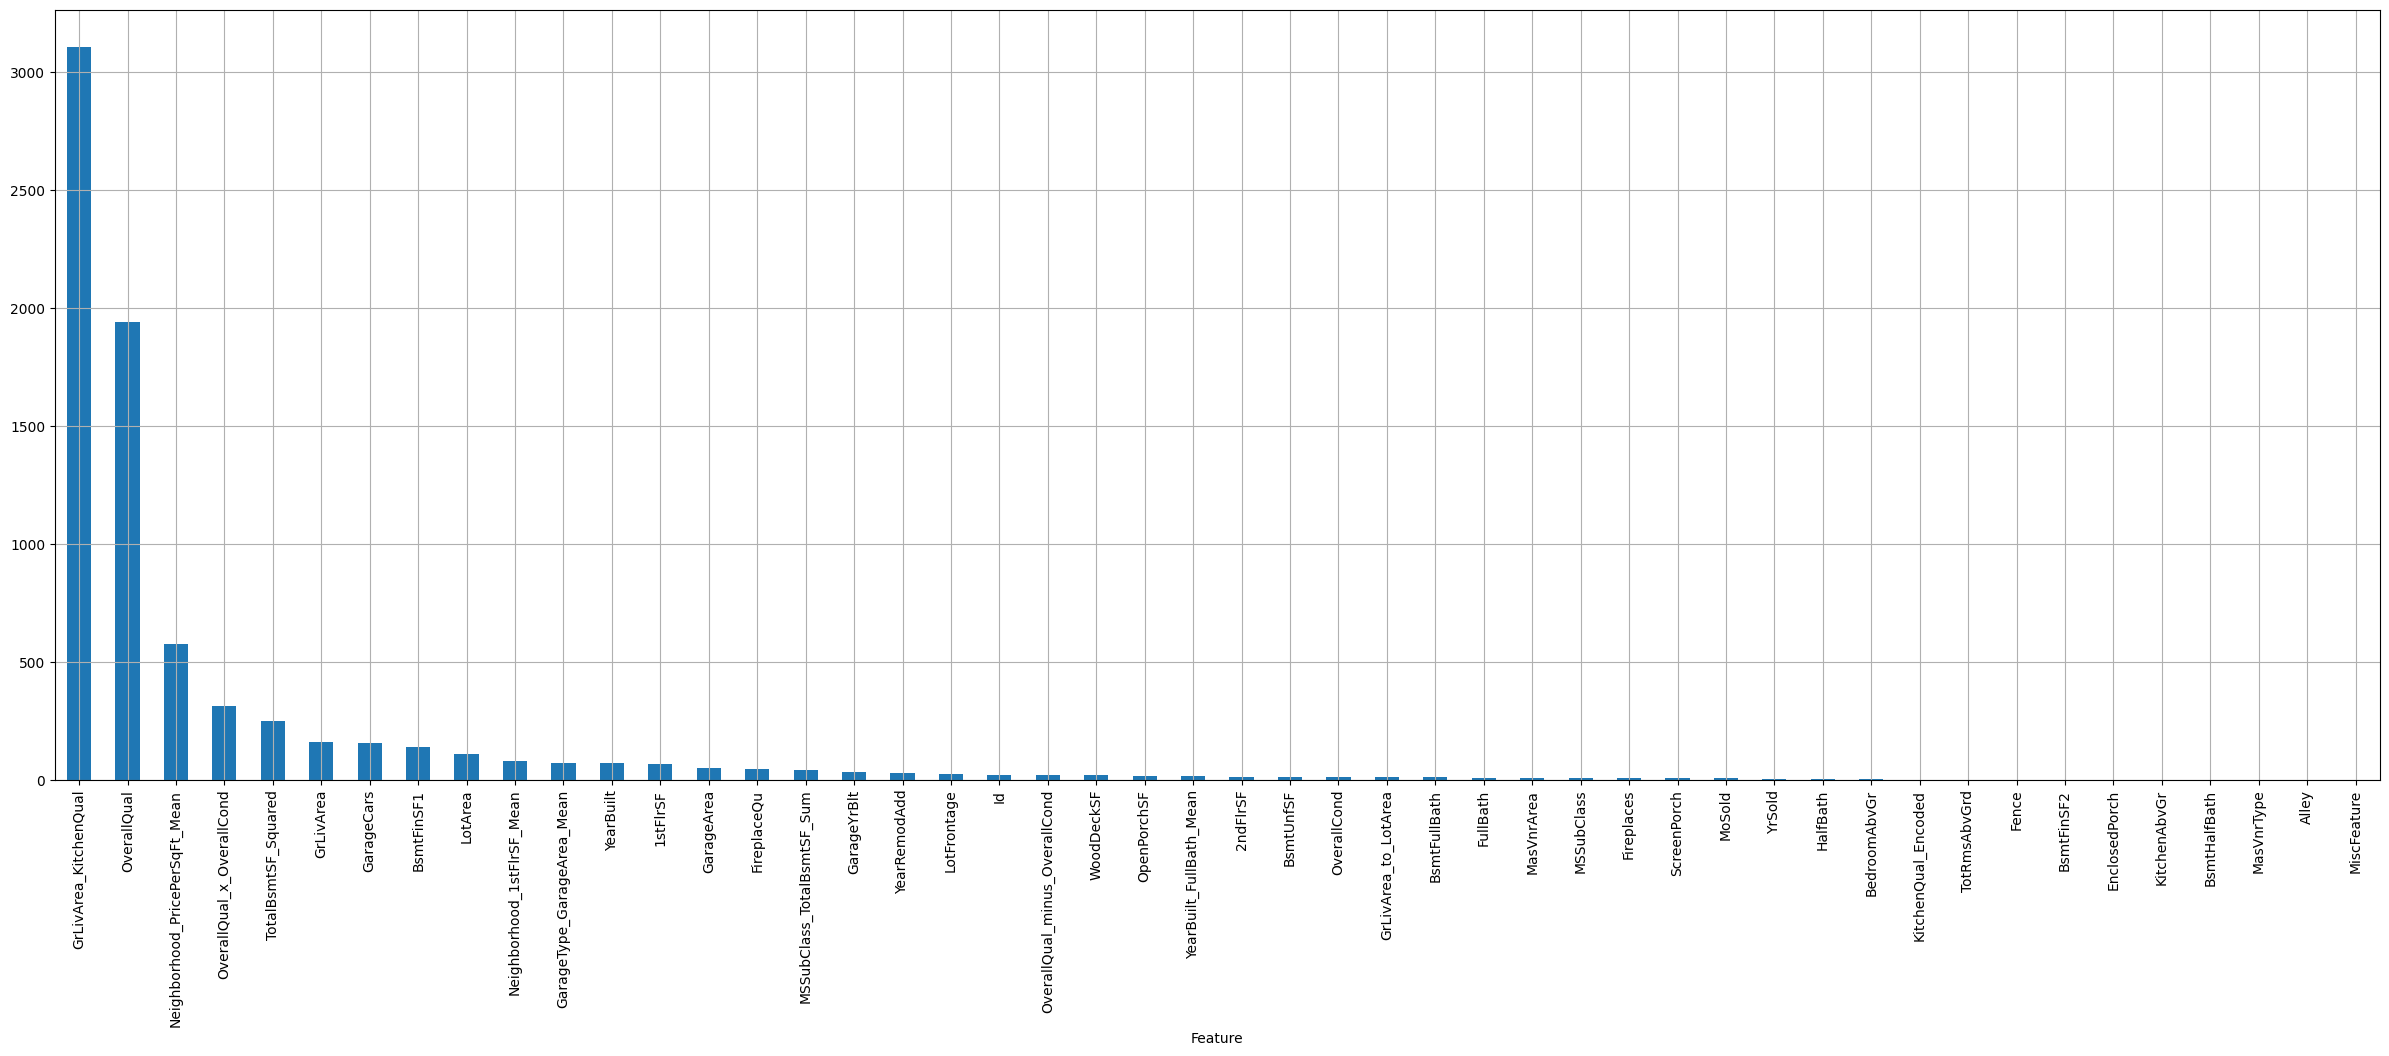

In [18]:
fast_fi = automl_ut.get_feature_scores('fast', test_df_fe, silent=True)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True);

In [17]:
print(automl_ut.create_model_str_desc())
playsound()

Final prediction for new objects = 
	0.14253 * 1 averaged models with config = "c:\Users\User\skillbox\HOMEWORKS\HWs\Lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.19420 * (5 averaged models Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM) +
			 0.15300 * (5 averaged models Lvl_0_Pipe_0_Mod_2_CatBoost) +
			 0.52202 * (5 averaged models Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost) +
			 0.13079 * (5 averaged models Lvl_0_Pipe_0_Mod_5_Tuned_XGBoost) 


	+ 0.17726 * 1 averaged models with config = "c:\Users\User\skillbox\HOMEWORKS\HWs\Lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.19771 * (5 averaged models Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM) +
			 0.23900 * (5 averaged models Lvl_0_Pipe_0_Mod_2_CatBoo

# 4. Выводы по проделанной работе  

<br>  
  
1. **Эффективность создания новых фичей**:
   - Изначально, без создания новых фичей, модель **TabularAutoML** показала MAE ≈16000, что является достаточно высоким значением ошибки.
   - После добавления новых фичей, MAE снизилось до **8368.85595301798**, что свидетельствует о значительном улучшении качества модели. Это подтверждает важность генерации новых признаков для повышения точности предсказаний.

<br>  

2. **Использование TabularUtilizedAutoML**:
   - Переход на **TabularUtilizedAutoML** позволил дополнительно снизить MAE до **6293.234658604452**. Это говорит о том, что данная версия модели лучше справляется с задачей регрессии, возможно, за счёт более эффективного использования данных или улучшенных алгоритмов.

<br>  

3. **Логарифмирование таргета**:
   - После логарифмирования целевой переменной, MAE на кросс-валидации составило **0.042922088497490615**. Это значительное улучшение метрики, что указывает на то, что логарифмирование таргета помогло модели лучше справляться с задачей, особенно если исходное распределение целевой переменной было скошено или имело выбросы. Логарифмирование, вероятно, сделало данные более "удобными" для модели, уменьшив влияние экстремальных значений.

<br>

4. **Общие наблюдения**:
   - Каждый этап улучшения (создание новых фичей, использование более продвинутой модели, логарифмирование таргета) вносил значительный вклад в снижение ошибки. Это подчеркивает важность тщательной предобработки данных и выбора подходящих методов моделирования.
   - Логарифмирование таргета оказалось особенно эффективным, что может быть полезным приёмом в задачах регрессии, где целевая переменная имеет широкий диапазон значений или асимметричное распределение.

<br>

В целом, проделанная работа демонстрирует, что тщательная предобработка данных и выбор подходящих методов моделирования могут значительно улучшить качество предсказаний в задачах регрессии.